In [ ]:
"""
Project : Employee Sentiment Analysis
Programmer: Nishigandha Wankhade

Information:
The main goal is to evaluate employee sentiment and engagement by performing the following:
    - Sentiment Labeling: Automatically label each message as Positive, Negative, or Neutral.
    - Exploratory Data Analysis (EDA): Analyze and visualize the data to understand its structure and underlying trends.
    - Employee Score Calculation: Compute a monthly sentiment score for each employee based on their messages.
    - Employee Ranking: Identify and rank employees by their sentiment scores.
    - Flight Risk Identification: A Flight risk is any employee who has sent 4 or more negative mails in a given month.
    - Predictive Modeling: Develop a linear regression model to further analyze sentiment trends.

"""

# Installing the TensorFlow Keras Package

The following command installs the `tf-keras` package, which is a high-level neural networks API, written in Python and capable of running on top of TensorFlow. It simplifies building and training deep learning models.


In [ ]:
pip install tf-keras
"""
TO SOLVE:  RuntimeError: Failed to import transformers.models.roberta.modeling_tf_roberta because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

"""

# Importing Libraries and Setting Up the Environment

In [2]:
import pandas as pd   # for null handling, date formating, reading csv file
import numpy as np    # for feature engineering

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wankh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wankh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\wankh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Dataset

The dataset is loaded from a CSV file located at the specified path using `pandas.read_csv()`. This function reads the CSV file into a DataFrame named `data`, which will be used for further analysis.


In [36]:
 # =========== Reading dataset from csv file ================
data = pd.read_csv("C:/Users/Employee_Sentiment_Analysis/test(in).csv")

# Previewing the Dataset

The `head()` function displays the first 10 rows of the DataFrame `data`. This helps to quickly inspect the structure, columns, and sample values of the dataset before further processing.


In [37]:
data.head(10) # displaying first 10 records from the file

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com
5,RE: Favor,"sure, just call me the bank that delivers.\n \...",10/23/2011,eric.bass@enron.com
6,MG Inventory Summaries,Inventory summaries for both MGL and MGMCC as ...,4/5/2010,kayne.coulter@enron.com
7,Forgot the Attachment,Please print attachment and make sure that e:m...,4/21/2010,patti.thompson@enron.com
8,Garvin Brown - AXIA Sr. Power Scheduler,Please advise me of your interest in Garvin's ...,2/7/2010,sally.beck@enron.com
9,More Dallas ASE Information,The start time for Tuesday morning has been ch...,2/6/2010,kayne.coulter@enron.com


# Data Cleaning: Checking for Missing Values

This step checks the dataset for any missing (NULL) values using `isnull().sum()`. It sums up the number of null entries in each column to identify data quality issues.

Since the output indicates zero missing values, the dataset does not require imputation or handling of nulls at this stage.


In [38]:
#========================= DATA CLEANING ==============================
# 1. Check for missing values
print(data.isnull().sum())    # Result shows no NULL values are present

Subject    0
body       0
date       0
from       0
dtype: int64


# Dataset Dimensions

The `.shape` attribute returns a tuple indicating the size of the DataFrame in terms of rows and columns. 

- The first value represents the total number of records (rows).
- The second value represents the total number of features or columns.


In [39]:
data.shape  # shows total number of records and total columns (total records, total columns)

(2191, 4)

# Dataset Summary and Data Types

The `data.info()` method provides a concise summary of the DataFrame, including:

- Number of non-null values in each column (useful for spotting missing data).
- Data types of each column (e.g., `object`, `int64`, `float64`).
- Memory usage.

In [40]:
data.info()  # To check details of database,like any missing data(with Non-Null count), data types (here date id also of an object type, 
             # so neet to convert it into proper datetime format) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


# Date Column Conversion and Sorting

- The `'date'` column is converted from an `object` (string) type to a proper `datetime` format using `pd.to_datetime()`.  
  The parameter `errors='coerce'` ensures that any invalid date values are converted to `NaT` (Not a Time).

- The dataset is then sorted in ascending order based on the `'date'` column to maintain chronological order.

- Finally, the first few rows of the updated DataFrame are displayed to verify the changes.


In [41]:
# 2. Converting 'date' column data type to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Sorting values as per Dates
data = data.sort_values('date')

# Displaying data
data.head()

,Subject,body,date,from
1417,ERCOT Readiness Update attached,We at TradersNews are gearing up to launch our...,2010-01-01,johnny.palmer@enron.com
904,RE: data,Well have to go to Vegas I guess??\n\n\n,2010-01-02,eric.bass@enron.com
1753,Re: Wellhead Accrual Income,"Melissa,\n\nHere are the accrual values for Q1...",2010-01-02,lydia.delgado@enron.com
1019,(No Subject),Attached are two of TradersNews Energy's three...,2010-01-02,don.baughman@enron.com
875,Tiger recruiting #1,"Sorry, but this is funny . . .\nhttp://auburn....",2010-01-02,lydia.delgado@enron.com


# Verifying Date Column Conversion

Using `data.info()` again to confirm that the `'date'` column has successfully been converted to the `datetime64[ns]` data type. This ensures proper handling of date operations moving forward.


In [42]:
# To check 'date' changes to datetime format
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2191 entries, 1417 to 1442
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Subject  2191 non-null   object        
 1   body     2191 non-null   object        
 2   date     2191 non-null   datetime64[ns]
 3   from     2191 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 85.6+ KB


# Statistical Summary of the Dataset

The `describe()` function provides a comprehensive summary of the dataset:

- For **numerical columns**, it shows count, mean, standard deviation, min, max, and quartiles.
- For **categorical/object columns**, it displays count, unique values, top (most frequent) value, and frequency.
- Using `include='all'` ensures the summary includes **all columns**, regardless of their data type.

This helps in understanding the distribution and characteristics of each feature.


In [43]:
data.describe(include='all')

,Subject,body,date,from
count,2191,2191,2191,2191
unique,1251,1539,NaN,10
top,(No Subject),\n\n,NaN,lydia.delgado@enron.com
freq,141,21,NaN,284
mean,NaN,NaN,2010-12-31 02:17:21.716111360,NaN
min,NaN,NaN,2010-01-01 00:00:00,NaN
25%,NaN,NaN,2010-06-30 12:00:00,NaN
50%,NaN,NaN,2011-01-01 00:00:00,NaN
75%,NaN,NaN,2011-06-30 12:00:00,NaN
max,NaN,NaN,2011-12-31 00:00:00,NaN


# Text Processing and Cleaning

This step prepares the text data in the `'body'` and `'Subject'` columns for analysis by performing the following:

- **Stop Words:** Uses NLTK’s English stopwords to remove common, less meaningful words (e.g., "the", "and").
- **Lemmatization:** Converts words to their base form (e.g., "running" → "run") using WordNet lemmatizer for better text normalization.
- **Cleaning Function (`clean_text`):**  
  - Converts text to lowercase for uniformity.  
  - Removes email addresses and URLs to eliminate irrelevant tokens.  
  - Removes punctuation and special characters, retaining only alphabets and spaces.  
  - Splits text into words, filters out stopwords, and lemmatizes the remaining words.  
  - Joins the processed words back into a clean string.

- **Applying Cleaning:** The cleaning function is applied to the `'body'` and `'Subject'` columns, creating new columns `'clean_body'` and `'clean_subject'` with the processed text.


In [44]:
#=============== TEXT PROCESSING (for body column) =========================

stop_words = set(stopwords.words('english')) # Creates a set of stop words in English
lemmatizer = WordNetLemmatizer()  # Initializes a lemmatizer using WordNet

def clean_text(text):
    try:
        text = text.lower()  # Lowercasing: Normalize casing
        text = re.sub(r'\S+@\S+', '', text) # Remove Email Signatures 
        text = re.sub(r'http\S+', '', text) # Removes URLs
        text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove Punctuation & Special Characters (only alpabates and spaces will remain)
       #text =re.sub(r'\s+', ' ', text).strip() # normalize spaces
        words = text.split()
        words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words] #  Lemmatization helps in normalizing words e.g., "running" to "run"
        return ' '.join(words)
    except:
        return ""

data['clean_body'] = data['body'].apply(clean_text)
data['clean_subject'] = data['Subject'].apply(clean_text)
    

# Previewing the Dataset

The `head()` function displays the first 5 rows of the DataFrame `data`.

In [45]:
data.head() # displaying top 5 values from the dataset

,Subject,body,date,from,clean_body,clean_subject
1417,ERCOT Readiness Update attached,We at TradersNews are gearing up to launch our...,2010-01-01,johnny.palmer@enron.com,tradersnews gearing launch ercot hourly index ...,ercot readiness update attached
904,RE: data,Well have to go to Vegas I guess??\n\n\n,2010-01-02,eric.bass@enron.com,well go vega guess,data
1753,Re: Wellhead Accrual Income,"Melissa,\n\nHere are the accrual values for Q1...",2010-01-02,lydia.delgado@enron.com,melissa accrual value q detail follow jan feb ...,wellhead accrual income
1019,(No Subject),Attached are two of TradersNews Energy's three...,2010-01-02,don.baughman@enron.com,attached two tradersnews energy three new hour...,subject
875,Tiger recruiting #1,"Sorry, but this is funny . . .\nhttp://auburn....",2010-01-02,lydia.delgado@enron.com,sorry funny,tiger recruiting


# Date Parsing: Extracting Time-Based Features

From the `'date'` column, we extract additional time-related features to enhance analysis:

- `month`: Extracts the month (1–12) from the date.
- `weekday`: Returns the day of the week as an integer (Monday=0, Sunday=6).
- `is_weekend`: Boolean flag indicating whether the date falls on a weekend (Saturday or Sunday).

These features are useful for identifying patterns and trends based on temporal factors.


In [46]:
#==================== Date PARSING (Extracting FEATURES) from date column==============
data['month'] = data['date'].dt.month
data['weekday'] = data['date'].dt.dayofweek
data['is_weekend'] = data['weekday'].isin([5,6])

data.head()

,Subject,body,date,from,clean_body,clean_subject,month,weekday,is_weekend
1417,ERCOT Readiness Update attached,We at TradersNews are gearing up to launch our...,2010-01-01,johnny.palmer@enron.com,tradersnews gearing launch ercot hourly index ...,ercot readiness update attached,1,4,False
904,RE: data,Well have to go to Vegas I guess??\n\n\n,2010-01-02,eric.bass@enron.com,well go vega guess,data,1,5,True
1753,Re: Wellhead Accrual Income,"Melissa,\n\nHere are the accrual values for Q1...",2010-01-02,lydia.delgado@enron.com,melissa accrual value q detail follow jan feb ...,wellhead accrual income,1,5,True
1019,(No Subject),Attached are two of TradersNews Energy's three...,2010-01-02,don.baughman@enron.com,attached two tradersnews energy three new hour...,subject,1,5,True
875,Tiger recruiting #1,"Sorry, but this is funny . . .\nhttp://auburn....",2010-01-02,lydia.delgado@enron.com,sorry funny,tiger recruiting,1,5,True


# Email Normalization and Duplicate Handling

## 1. Email Address Normalization
To ensure consistency and prevent mismatches due to casing or extra spaces:
- The values in the `'from'` column are converted to lowercase and stripped of leading/trailing whitespace.

In [47]:
#==================== Email Address NORMALIZATION ==============
""" To ensure there are no typos or inconsistancies"""
data['from'] = data['from'].str.lower().str.strip()

#================== HANDLING DUPLICATES ================
data.drop_duplicates(subset = ['body', 'from', 'date'], inplace = True)

In [48]:
data.info()    # Total records are same as previous means no duplicate recoreds found

<class 'pandas.core.frame.DataFrame'>
Index: 2191 entries, 1417 to 1442
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Subject        2191 non-null   object        
 1   body           2191 non-null   object        
 2   date           2191 non-null   datetime64[ns]
 3   from           2191 non-null   object        
 4   clean_body     2191 non-null   object        
 5   clean_subject  2191 non-null   object        
 6   month          2191 non-null   int32         
 7   weekday        2191 non-null   int32         
 8   is_weekend     2191 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int32(2), object(5)
memory usage: 139.1+ KB


# Creating Copies for VADER and BERT Analysis

To maintain the integrity of the original cleaned dataset and allow independent processing for different sentiment analysis methods:

- Two separate DataFrame copies are created:
  - `df_vader`: For sentiment analysis using **VADER**.
  - `df_bert`: For sentiment analysis using **BERT**.

This modular approach helps in comparing results without altering the original dataset.


In [49]:
df_vader = data.copy()    # creating copy of original data for VADER and BERT analysis. 
df_bert = data.copy()

# Task 1: Sentiment Labeling Using VADER (NLTK)

This step uses **VADER (Valence Aware Dictionary and sEntiment Reasoner)**, a pre-trained rule-based sentiment analysis model from NLTK, specifically tuned for social media and short text.

### Steps:

- `SentimentIntensityAnalyzer()` initializes the VADER analyzer.
- `get_sentiment()` function:
  - Computes the **compound sentiment score** (range: -1 to 1) for each text using `sid.polarity_scores(text)['compound']`.
  - Assigns sentiment labels based on score:
    - **Positive**: `score >= 0.5`
    - **Negative**: `score <= -0.05`
    - **Neutral**: Otherwise

- The function is applied to the `'body'` column of `df_vader` to generate sentiment labels.


In [50]:
# ===================== SENTIMENT LABELING USING VADER FROM NLTK (pre-trained sentiment analysis model ) ===================

sid = SentimentIntensityAnalyzer() # initializing the VADER sentiment Analyzer

def get_sentiment(text):
    score = sid.polarity_scores(text)['compound']  # calculates the score from -1 to 1 based on text 
    
    if score >= 0.5:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    
df_vader['sentiment'] = df_vader['body'].apply(get_sentiment) # calling function get_sentiment for each email body in the dataFrame

# Sentiment Distribution Visualization (VADER)

This bar plot shows the distribution of sentiment labels (Positive, Negative, Neutral) predicted by the **VADER Sentiment Analyzer**.

- `sns.countplot()` displays the count of messages for each sentiment class.
- `hue='sentiment'` ensures bars are grouped by sentiment category.
- `palette='Set2'` sets a visually appealing color scheme.
- Titles and axis labels enhance readability.


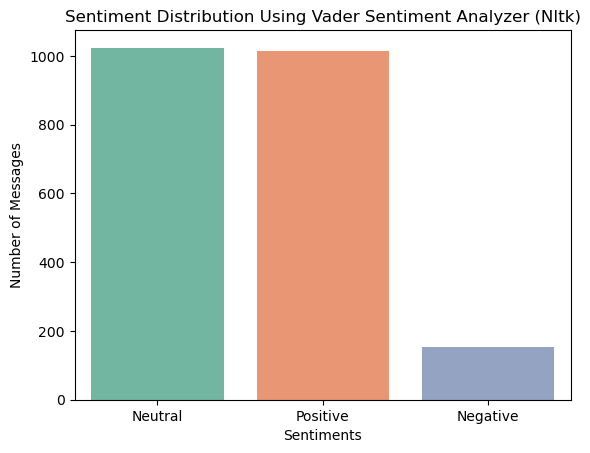

In [51]:
#============================= BAR PLOT FOR VADER SENTIMENT ANALYZER ===================
sns.countplot(x= 'sentiment', hue='sentiment', data= df_vader, palette= 'Set2')
plt.title("Sentiment Distribution Using Vader Sentiment Analyzer (Nltk)")
plt.xlabel('Sentiments')
plt.ylabel('Number of Messages')
plt.show()

# Task 1: Sentiment Labeling Using BERT/Roberta (LLM from Hugging Face Transformers)

This section uses a **pre-trained BERT-based transformer model** for sentiment analysis:

- Model Used: `cardiffnlp/twitter-roberta-base-sentiment` — optimized for social media and short text.
- Alternatively, models like `distilbert-base-uncased-finetuned-sst-2-english` can also be used.

### Steps:

- `pipeline("sentiment-analysis", model=...)`: Loads a transformer pipeline for sentiment prediction.
- `bert_sentiment()`:
  - Applies the pipeline to the input text (truncated to 512 tokens).
  - Extracts and returns the predicted sentiment label (`'LABEL_0'`, `'LABEL_1'`, or `'LABEL_2'`).
  - If an error occurs, defaults to `"Neutral"`.

- Sentiment labels are applied to the `'body'` column and stored in a new `'sentiment'` column of the `df_bert` DataFrame.


In [19]:
# ===================== SENTIMENT LABELING USING BERT/Roberta Model (LLM) from transformers ====================

# Loading Sentiment Pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

#sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def bert_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0] # limit to max 512 tokens per message
        return result['label']  # 'LABEL_0', 'LABEL_1'
    except:
        return "Neutral"
    
df_bert['sentiment'] = df_bert['body'].apply(bert_sentiment); # calling function bert_sentiment for each email body in the dataFrame


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0


# Displaying Records After BERT Sentiment Analysis

After applying the **BERT/Roberta-based sentiment analysis**, the first few records are displayed to verify that sentiment labels have been successfully added to the dataset.


In [20]:
print("\n ============= DISPLAYING RECORDS AFTER USING BERT SENTIMENT ANALYZER ===================== \n")
df_bert.head()


 ============= DISPLAYING RECORDS AFTER USING BERT SENTIMENT ANALYZER ===================== 



,Subject,body,date,from,clean_body,clean_subject,month,weekday,is_weekend,sentiment
1417,ERCOT Readiness Update attached,We at TradersNews are gearing up to launch our...,2010-01-01,johnny.palmer@enron.com,tradersnews gearing launch ercot hourly index ...,ercot readiness update attached,1,4,False,LABEL_1
904,RE: data,Well have to go to Vegas I guess??\n\n\n,2010-01-02,eric.bass@enron.com,well go vega guess,data,1,5,True,LABEL_1
1753,Re: Wellhead Accrual Income,"Melissa,\n\nHere are the accrual values for Q1...",2010-01-02,lydia.delgado@enron.com,melissa accrual value q detail follow jan feb ...,wellhead accrual income,1,5,True,LABEL_1
1019,(No Subject),Attached are two of TradersNews Energy's three...,2010-01-02,don.baughman@enron.com,attached two tradersnews energy three new hour...,subject,1,5,True,LABEL_1
875,Tiger recruiting #1,"Sorry, but this is funny . . .\nhttp://auburn....",2010-01-02,lydia.delgado@enron.com,sorry funny,tiger recruiting,1,5,True,LABEL_1


# Mapping BERT Sentiment Labels to Human-Readable Format

The transformer model (`cardiffnlp/twitter-roberta-base-sentiment`) returns sentiment predictions in the form of:
- `LABEL_0` → Negative
- `LABEL_1` → Neutral
- `LABEL_2` → Positive

To make these labels more interpretable:

- A `label_map` dictionary is defined.
- The `map()` function is applied to convert raw labels into descriptive text (`'Negative'`, `'Neutral'`, `'Positive'`).
- The new human-readable sentiment labels are stored in a new column: `'sentiment_labels'`.


In [21]:
label_map = {'LABEL_0': 'Negative', 'LABEL_1':'Neutral', 'LABEL_2':'Positive'} # Mapping the original output labels to Positive, Negative and Neutral as per labels 0,1 & 2
df_bert['sentiment_labels'] = df_bert['sentiment'].map(label_map) # applying new labels to the 'sentiment' column

# Displaying the Last 5 Records After Sentiment Mapping (BERT)

To verify that sentiment labels have been correctly mapped to their human-readable form (`'Negative'`, `'Neutral'`, `'Positive'`), the last few records of the updated `df_bert` DataFrame are displayed.


In [ ]:
df_bert.tail() # displaying last 5 records from the dataFrame

# Exporting Sentiment-Labeled Data to CSV

After sentiment labeling and preprocessing, the final step is to export the updated DataFrame (`df_bert`) to a CSV file for further use or sharing.

- `to_csv()` writes the DataFrame to the specified path.
- `index=False` ensures that the DataFrame index is not included in the CSV output.


In [24]:
# ============ WRITING DATA FROM DATAFRAME TO CSV FILE ======================
df_bert.to_csv('C:/Users/Employee_Sentiment_Analysis/Sentiments_Data_by_BERT.csv', index = False)

# Sentiment Distribution Visualization (BERT)

This bar plot illustrates the distribution of sentiment labels predicted by the **BERT Sentiment Analyzer**.

- `sns.countplot()` displays the count of messages for each sentiment category (`Positive`, `Neutral`, `Negative`).
- `hue='sentiment_labels'` groups bars by sentiment class with distinct colors.
- The `Set2` color palette enhances visual clarity.
- Proper titles and axis labels improve interpretability.



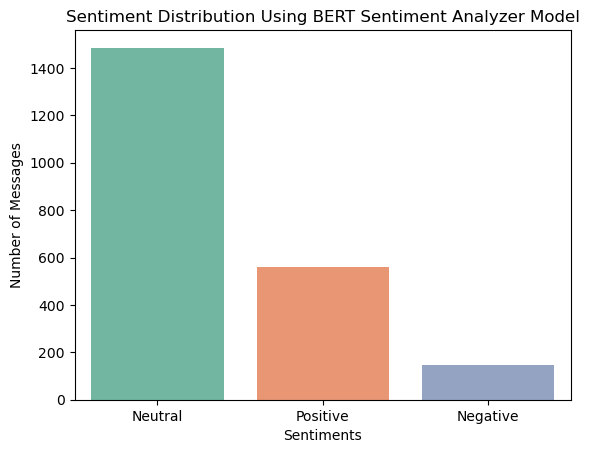

In [25]:
#============================= BAR PLOT FOR BERT SENTIMENT ANALYZER ===================
# Distribution of Sentiments
sns.countplot(x= 'sentiment_labels', hue='sentiment_labels', data= df_bert, palette= 'Set2')
plt.title("Sentiment Distribution Using BERT Sentiment Analyzer Model")
plt.xlabel('Sentiments')
plt.ylabel('Number of Messages')
plt.show()

# Creating a Copy of Data for DistilBERT Sentiment Analysis

To keep the original cleaned dataset intact and enable separate processing for the DistilBERT model:

- A copy of the original data is created as `df_distilbert`.
- This ensures any modifications or analysis specific to DistilBERT do not affect other datasets.

In [26]:
df_distilbert = data.copy()  # copying data for DistilBERT model, not needed but on safer side

# Task 1: Sentiment Labeling Using DistilBERT Model

This section performs sentiment analysis using the **DistilBERT** model fine-tuned on the SST-2 dataset, which is optimized for binary sentiment classification (Positive/Negative).

### Steps:

- Loads a sentiment analysis pipeline with `distilbert-base-uncased-finetuned-sst-2-english` model.
- Defines `bert_sentiment()` function:
  - Processes the input text (truncated to 512 tokens).
  - Returns the predicted label (`'POSITIVE'` or `'NEGATIVE'`).
  - Returns `"Neutral"` as a fallback in case of exceptions.
- Applies the function on the `'body'` column of the copied DataFrame `df_distilbert` to generate sentiment labels.

In [27]:
# ===================== SENTIMENT LABELING USING DISTILED BERT Model ====================

# Loading Sentiment Pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def bert_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0] # Token limit to max 512 tokens per message as input to BERT-based model
        return result['label']  # 'LABEL_0', 'LABEL_1'
    except:
        return "Neutral"
       
df_distilbert['sentiment'] = df_distilbert['body'].apply(bert_sentiment)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


# Displaying Records After DistilBERT Sentiment Analysis

The first few rows of `df_distilbert` are displayed to verify that sentiment labels (`POSITIVE`, `NEGATIVE`, or `Neutral`) have been successfully applied to the email bodies.

In [28]:
"""
model="distilbert-base-uncased-finetuned-sst-2-english" 

Returns only two labels, LABEL_0 for 'POSITIVE' and LABEL_1 for 'NEGATIVE'.
It does not support "NEUTRAL"
because the Stanford Sentiment Treebank (SST-2) dataset it was fine-tuned on is binary. 
Neutral is not part of this model's classification, as it's a binary sentiment model (trained on the SST-2 dataset, which is binary).
"""
df_distilbert.head()

,Subject,body,date,from,clean_body,clean_subject,month,weekday,is_weekend,sentiment
1417,ERCOT Readiness Update attached,We at TradersNews are gearing up to launch our...,2010-01-01,johnny.palmer@enron.com,tradersnews gearing launch ercot hourly index ...,ercot readiness update attached,1,4,False,NEGATIVE
904,RE: data,Well have to go to Vegas I guess??\n\n\n,2010-01-02,eric.bass@enron.com,well go vega guess,data,1,5,True,NEGATIVE
1753,Re: Wellhead Accrual Income,"Melissa,\n\nHere are the accrual values for Q1...",2010-01-02,lydia.delgado@enron.com,melissa accrual value q detail follow jan feb ...,wellhead accrual income,1,5,True,NEGATIVE
1019,(No Subject),Attached are two of TradersNews Energy's three...,2010-01-02,don.baughman@enron.com,attached two tradersnews energy three new hour...,subject,1,5,True,NEGATIVE
875,Tiger recruiting #1,"Sorry, but this is funny . . .\nhttp://auburn....",2010-01-02,lydia.delgado@enron.com,sorry funny,tiger recruiting,1,5,True,POSITIVE


# Sentiment Distribution Visualization (DistilBERT)

This bar plot shows the sentiment distribution predicted by the **DistilBERT Sentiment Analyzer**.

- `sns.countplot()` displays the count of messages for each sentiment category (`POSITIVE`, `NEGATIVE`, or `Neutral`).
- The `hue='sentiment'` parameter colors the bars by sentiment class.
- The `Set2` palette is used for clear and visually appealing differentiation.
- The plot includes descriptive axis labels and a title.

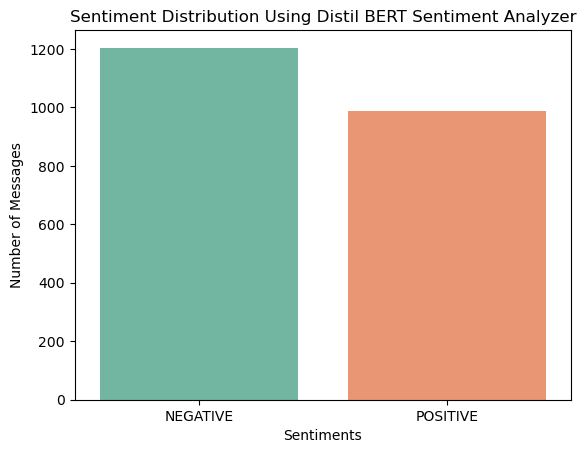

In [29]:
#============================= BAR PLOT FOR DISTIL-BERT SENTIMENT ANALYZER ===================
sns.countplot(x= 'sentiment', hue='sentiment', data= df_distilbert, palette= 'Set2')
plt.title("Sentiment Distribution Using Distil BERT Sentiment Analyzer")
plt.xlabel('Sentiments')
plt.ylabel('Number of Messages')
plt.show()

# Task 2: Exploratory Data Analysis (EDA): Monthly Sentiment Trends

This analysis explores how employee sentiment varies over time on a monthly basis:

- The `date` column in `df_bert` is converted to a **monthly period** using `.dt.to_period('M')` to facilitate aggregation by month.
- Sentiment counts (`Positive`, `Neutral`, `Negative`) are grouped by month using `.groupby()` and `.unstack()` to reshape the data.
- Missing values are filled with zero for months without certain sentiment labels.
- A **line plot** visualizes the monthly sentiment trends, showing fluctuations in the number of messages per sentiment over time.

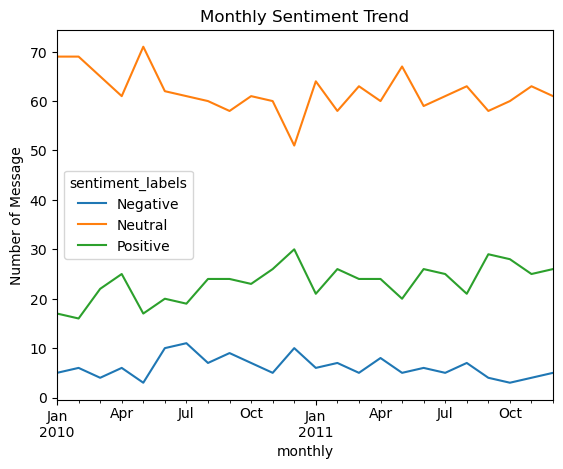

In [30]:
# ================== TASK 2: Exploratory Data Analysis (EDA) =====================

# Monthly Sentiment Trends
df_bert['monthly'] = df_bert['date'].dt.to_period('M')  #converts the datetime column (df['date']) into a monthly period, like 2023-04-15 -> 2023-04
                        # helpful to perform grouping by month, to trace monthly employee sentiments, to generate monthly trend charts

monthly_sentiment = df_bert.groupby(['monthly','sentiment_labels']).size().unstack().fillna(0)
monthly_sentiment.plot(kind = 'line', title = 'Monthly Sentiment Trend')
plt.ylabel("Number of Message")
plt.show()
    

# Task 3: Employee Monthly Sentiment Score Calculation

This step computes a **monthly sentiment score** for each employee based on their messages:

### Methodology:
1. Assign numeric scores to sentiment labels:
   - **Positive** = +1
   - **Negative** = -1
   - **Neutral** = 0 (no impact)
2. Map these scores to each message in the dataset.
3. Group messages by employee (`from` column) and by month (`date` converted to monthly period).
4. Sum the scores within each employee-month group to get the **monthly sentiment score**.
5. Resetting score each month is inherent as grouping is done on a monthly basis.

### Code:

In [31]:
# ===================== TASK 3: Employee Score Calculation =========================
#  Compute a monthly sentiment score for each employee based on their messages
"""
1. For each employee, assign a score to each message: 
     - Positive Message: +1
     - Negative Message: –1
     - Neutral Message: 0 (no effect)
2. Aggregate these scores on a monthly basis for each employee.
3. Ensure that the score resets at the beginning of each new month.
4. Clearly document your method for grouping messages by month and calculating the cumulative score.
Notes:
 Accuracy in the aggregation process is essential, as the resulting scores are used for subsequent ranking and risk analysis.

"""

score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0} # assigning Numeric Value to Each sentiment
df_bert['score'] = df_bert['sentiment_labels'].map(score_map) # Converting sentiment labels in df_bert to numerical scores using mapping

employee_monthly_score = df_bert.groupby([df_bert['from'], df_bert['date'].dt.to_period('M')])['score'].sum().reset_index() 
    # Suming up the sentiment scores for each employee per month after grouping all emails by employee and a month
    
employee_monthly_score.columns = ['employee', 'month', 'monthly_score']  # renaming the resulting columns

# Displaying Employee Monthly Sentiment Scores

The `employee_monthly_score` DataFrame contains the aggregated monthly sentiment scores for each employee.

- Columns:
  - `employee`: Employee email or identifier.
  - `month`: Month (period format) for which the score is calculated.
  - `monthly_score`: Sum of sentiment scores (+1, 0, -1) for that employee during the month.

In [32]:
employee_monthly_score

,employee,month,monthly_score
0,bobette.riner@ipgdirect.com,2010-01,0
1,bobette.riner@ipgdirect.com,2010-02,4
2,bobette.riner@ipgdirect.com,2010-03,1
3,bobette.riner@ipgdirect.com,2010-04,1
4,bobette.riner@ipgdirect.com,2010-05,2
...,...,...,...
235,sally.beck@enron.com,2011-08,-1
236,sally.beck@enron.com,2011-09,0
237,sally.beck@enron.com,2011-10,4
238,sally.beck@enron.com,2011-11,3


# Task 4: Employee Ranking Based on Monthly Sentiment Scores

## Objective:
Rank employees monthly based on their sentiment scores, identifying the top positive and negative performers.

## Methodology:
1. **Top Three Positive Employees per Month**:
   - Group data by month.
   - Within each month, select the three employees with the **highest** monthly sentiment scores using `nlargest`.
   
2. **Top Three Negative Employees per Month**:
   - Group data by month.
   - Within each month, select the three employees with the **lowest** monthly sentiment scores using `nsmallest`.

3. Sorting:
   - The rankings are derived directly from the monthly sentiment scores computed in Task 3.
   - If scores are tied, employees can be sorted alphabetically by their identifier (`employee`) to maintain consistency.

4. The results are displayed as two separate DataFrames, clearly showing monthly top positive and negative employees.

In [70]:
#======================= TASK 4: EMPLOYEE RANKING ========================
"""
Objective:
     Generate ranked lists of employees based on their monthly sentiment scores.
Requirements:
    1. Create two distinct lists: 
        - Top Three Positive Employees: The three employees with the highest positive scores in a given month.
        - Top Three Negative Employees: The three employees with the lowest (most negative) scores in a given month.
    2. Sort them first in descending order and then in alphabetical order.
    3. Ensure that the ranking is clearly derived from the monthly scores calculated in Task 3.
    4. Present the rankings in a clear and organized format (e.g., tables or charts).
Notes:
 Your report should include a brief discussion of how these rankings were determined.

"""

# Top 3 Positive Employees per Month 
top_positive_emp = (
    employee_monthly_score.groupby('month', group_keys=False)   
    .apply(lambda x: x.nlargest(3, 'monthly_score')) # Groups data by month and then within each month,
                                                     # selecting 3 employees with highest sentiment scores
)


# Top 3 Negative Employees per Month 
top_negative_emp = (
    employee_monthly_score.groupby('month', group_keys=False)
    .apply(lambda x: x.nsmallest(3, 'monthly_score')) # Groups data by month and then within each month,
                                                     # selecting 3 employees with lowest sentiment scores
)

print("\nTop 3 Positive Employees per Month:\n", top_positive_emp)
print("\nTop 3 Negative Employees per Month:\n", top_negative_emp)


Top 3 Positive Employees per Month:
                         employee    month  monthly_score
48           eric.bass@enron.com  2010-01              3
168     patti.thompson@enron.com  2010-01              3
24        don.baughman@enron.com  2010-01              2
1    bobette.riner@ipgdirect.com  2010-02              4
97       johnny.palmer@enron.com  2010-02              3
..                           ...      ...            ...
190     patti.thompson@enron.com  2011-11              5
22   bobette.riner@ipgdirect.com  2011-11              3
143      kayne.coulter@enron.com  2011-12              4
167      lydia.delgado@enron.com  2011-12              4
215      rhonda.denton@enron.com  2011-12              4

[72 rows x 3 columns]

Top 3 Negative Employees per Month:
                         employee    month  monthly_score
216         sally.beck@enron.com  2010-01             -1
0    bobette.riner@ipgdirect.com  2010-01              0
72         john.arnold@enron.com  2010-01     

C:\Users\wankh\AppData\Local\Temp\ipykernel_50188\3714213932.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, 'monthly_score')) # Groups data by month and then within each month,
C:\Users\wankh\AppData\Local\Temp\ipykernel_50188\3714213932.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nsmallest(3, 'monthly_score')) # Groups data by month and then 

# Overall Employee Sentiment Scores and Top Performers

## Objective:
- Aggregate the total sentiment scores across all months for each employee.
- Identify the top 3 overall positive employees with the highest cumulative sentiment scores.
- Identify the bottom 3 overall negative employees with the lowest cumulative sentiment scores.

## Steps:
1. **Aggregate Scores:** Sum monthly sentiment scores per employee using groupby.
2. **Save Results:** Export the aggregated scores to a CSV file for record-keeping.
3. **Top/Bottom Employees:**
   - Select the top 3 employees with the highest total sentiment scores.
   - Select the bottom 3 employees with the lowest total sentiment scores.

In [76]:
# ============== FOR POSITIVE SENTIMENT EMPLOYEES =========================

# Aggregate total sentiment scores per employee
employee_total_scores = employee_monthly_score.groupby('employee', as_index=False)['monthly_score'].sum()


# Write Top 3 Positive Employees per Month to CSV
employee_total_scores.to_csv('C:/Users/Employee_Sentiment_Analysis/employee_total_score.csv', index=False)


# Top 3 overall positive employees (highest scores)
top_3_positive_employees = employee_total_scores.nlargest(3, 'monthly_score')

# Bottom 3 overall negative employees (lowest scores)
bottom_3_negative_employees = employee_total_scores.nsmallest(3, 'monthly_score')


print("\nOverall Top 3 Positive Employees:\n", top_3_positive_employees )

print("\nOverall Bottom 3 Negative Employees per Month:\n", bottom_3_negative_employees )




Overall Top 3 Positive Employees:
                   employee  monthly_score
4  johnny.palmer@enron.com             55
2      eric.bass@enron.com             52
6  lydia.delgado@enron.com             52

Overall Bottom 3 Negative Employees per Month:
                   employee  monthly_score
8  rhonda.denton@enron.com             26
1   don.baughman@enron.com             29
5  kayne.coulter@enron.com             32


# Visualization: Top 3 Positive Employees for January 2010

This section focuses on visualizing the employees with the highest sentiment scores for a specific month (January 2010).

### Process:
1. **Set Target Month:** Define the month to analyze (here, `'2010-01'`).
2. **Filter Data:** Extract the monthly sentiment scores for that month.
3. **Identify Top 3:** Select the top 3 employees with the highest sentiment scores in that month.
4. **Plot Bar Chart:** Visualize the sentiment scores using a horizontal bar chart with green shades representing positive sentiment strength.

The plot helps in quickly identifying the employees with the most positive sentiment contributions during the chosen month.

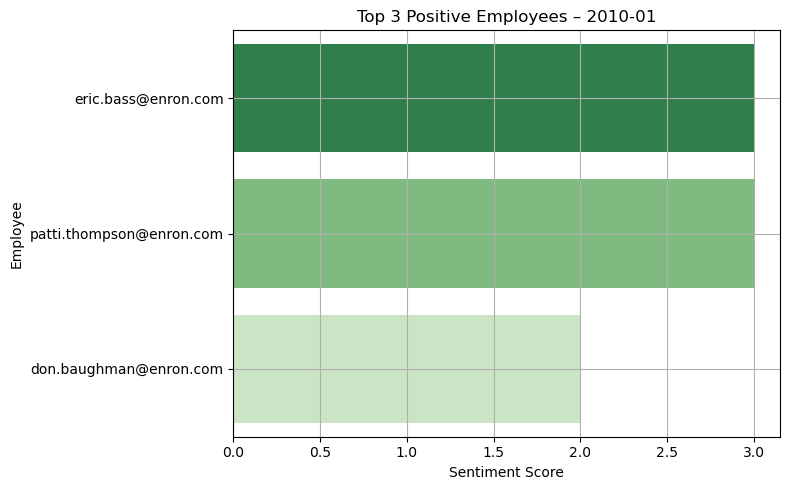

In [67]:
#==================== BAR CHART FOR TOP 3 POSITIVE EMPLOYEES FOR JAN 2010 ===================
# Set the month you want to analyze (e.g., January 2010)
target_month = '2010-01'

# Define the target month
target_month = '2010-01'

# Filter and get top 3 employees for that month
monthly_data = employee_monthly_score[employee_monthly_score['month'] == target_month]
top_employees = monthly_data.nlargest(3, 'monthly_score')

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.title(f"Top 3 Positive Employees – {target_month}")
sns.barplot(
    x='monthly_score',
    y='employee',
    data=top_employees,
    hue='employee',             # Add hue
    palette='Greens_r',
    dodge=False,                # avoid multiple bars per row
    legend=False                # Remove legend
)

# Customize chart
plt.title(f"Top 3 Positive Employees – {target_month}")
plt.xlabel("Sentiment Score")
plt.ylabel("Employee")
plt.grid(True)
plt.tight_layout()
plt.show();

# Visualization: Top 3 Negative Employees for January 2010

This plot highlights the employees with the lowest (most negative) sentiment scores for January 2010.

### Steps:
1. **Select Month:** Filter sentiment data for the target month (`'2010-01'`).
2. **Identify Bottom 3:** Extract the three employees with the lowest monthly sentiment scores.
3. **Plot Bar Chart:** Display these scores in a horizontal bar chart using shades of red to emphasize negative sentiment.

This visualization helps in identifying employees potentially at risk or expressing negative sentiment during the specified time period.

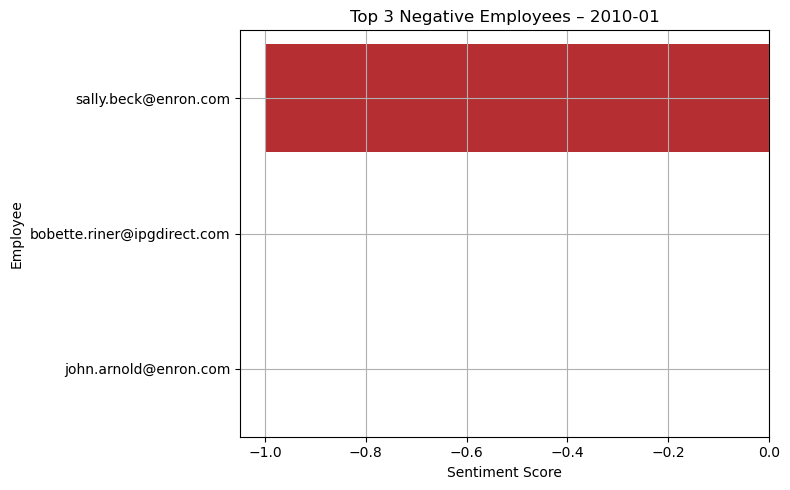

In [60]:
# ==================== BAR CHART FOR TOP 3 NEGATIVE EMPLOYEES FOR JAN 2010 ====================

# Define the target month
target_month = '2010-01'

# Filter data for the selected month
monthly_data = employee_monthly_score[employee_monthly_score['month'] == target_month]

# Get Bottom 3 Employees (lowest sentiment scores)
bottom_employees = monthly_data.nsmallest(3, 'monthly_score')

# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(
    x='monthly_score',
    y='employee',
    data=bottom_employees,
    hue='employee',
    palette='Reds_r',
    dodge=False,
    legend=False
)

# Customize chart
plt.title(f"Top 3 Negative Employees – {target_month}")
plt.xlabel("Sentiment Score")
plt.ylabel("Employee")
plt.grid(True)
plt.tight_layout()
plt.show();

# Advanced Employee Flight Risk Analysis

This analysis identifies employees who may be at risk of leaving the organization (flight risk) based on their email sentiment and engagement trends.

## Steps:

1. **Decreasing Monthly Sentiment Score Trend**  
   For each employee, we calculate the slope of their monthly sentiment scores using linear regression.  
   - A **negative slope** indicates a decline in sentiment over time, signaling potential dissatisfaction.

2. **Negative-to-Positive Sentiment Ratio**  
   We compute the ratio of negative to positive messages sent by each employee.  
   - A ratio **greater than 1** suggests more negative than positive messages, which may indicate disengagement.

3. **Engagement Trend (Message Count Slope)**  
   We analyze the trend of the employee’s monthly email volume by calculating the slope of their message counts over time.  
   - A **negative slope** indicates decreasing communication or engagement.

4. **Flagging Flight Risk**  
   An employee is flagged as a potential flight risk if all three conditions below are met:  
   - Sentiment score slope < 0 (decreasing sentiment)  
   - Negative-to-positive sentiment ratio > 1 (more negative messages)  
   - Engagement slope < 0 (decreasing message volume)

5. **Output**  
   The resulting dataset includes these calculated metrics and a flight risk flag (`Yes` or `No`) for each employee. This information is saved as a CSV file for further review.

---

This comprehensive approach combines sentiment and engagement data to help proactively identify employees who might be dissatisfied and at risk of leaving.

In [77]:
#=================================== ADVANCED ANALYSIS FOR FLAGGING FLIGHT RISKS ==============


# 1. Decreasing Monthly Score Trend
score_trend = employee_monthly_score.copy()
score_trend['month_num'] = score_trend['month'].astype(str).str.replace('-', '').astype(int)

employee_trends = (
    score_trend.groupby('employee')
    .apply(lambda df: np.polyfit(df['month_num'], df['monthly_score'], 1)[0])  # slope
    .reset_index(name='score_slope')
)

# 2. Negative-to-Positive Ratio
sentiment_counts = df_bert.groupby(['from', 'sentiment_labels'])['sentiment_labels'].count().unstack(fill_value=0)
sentiment_counts['neg_pos_ratio'] = sentiment_counts['Negative'] / sentiment_counts['Positive'].replace(0, 1)
sentiment_counts.reset_index(inplace=True)
sentiment_counts.rename(columns={'from': 'employee'}, inplace=True)

# 3. Engagement Trend (message count)
df_bert['month'] = df_bert['date'].dt.to_period('M')
engagement = df_bert.groupby(['from', 'month']).size().reset_index(name='msg_count')
engagement['month_num'] = engagement['month'].astype(str).str.replace('-', '').astype(int)

engagement_trend = (
    engagement.groupby('from')
    .apply(lambda df: np.polyfit(df['month_num'], df['msg_count'], 1)[0])  # slope
    .reset_index(name='engagement_slope')
)
engagement_trend.rename(columns={'from': 'employee'}, inplace=True)

# Merge all into a master dataframe
risk_df = employee_total_scores.merge(employee_trends, on='employee')
risk_df = risk_df.merge(sentiment_counts[['employee', 'neg_pos_ratio']], on='employee', how='left')
risk_df = risk_df.merge(engagement_trend, on='employee', how='left')

# Flagging Flight Risk: All 3 conditions met
risk_df['flight_risk'] = risk_df.apply(
    lambda row: 'Yes' if (row['score_slope'] < 0 and row['neg_pos_ratio'] > 1 and row['engagement_slope'] < 0)
    else 'No',
    axis=1
)

# Exporting
risk_df.to_csv('C:/Users/Employee_Sentiment_Analysis/flight_risk_flagged.csv', index=False)


C:\Users\wankh\AppData\Local\Temp\ipykernel_50188\666525308.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.polyfit(df['month_num'], df['monthly_score'], 1)[0])  # slope
C:\Users\wankh\AppData\Local\Temp\ipykernel_50188\666525308.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: np.polyfit(df['month_num'], df['msg_count'], 1)[0])  # slope


# Task 5: Flight Risk Identification Based on Negative Emails

## Objective:
Identify employees who are potentially at risk of leaving by analyzing their volume of negative emails over a rolling 30-day window.

## Approach:
- Filter emails classified as **Negative**.
- For each employee, scan through their negative emails sorted by date.
- For every email, define a 30-day window starting from that email's date.
- Count the number of negative emails sent by the employee within this 30-day period.
- Flag the employee as a **flight risk** if they have sent **4 or more negative emails** in any such rolling 30-day window.
- This method uses a rolling window rather than calendar months, providing a more precise view of recent negative sentiment bursts.

## Outcome:
- The flagged employees are compiled into a DataFrame with columns for:
  - Employee ID
  - Start and End dates of the 30-day window
  - Number of negative emails sent during that window
- The results help HR or management identify employees who may be struggling and require attention to improve engagement and retention.

In [34]:
#======================= TASK 5: FLIGHT RISK IDENTIFICATION =====================
"""
Objective:
 Identify employees who are at risk of leaving based on their monthly sentiment scores.
Requirements:
    - A Flight risk is any employee who has sent 4 or more negative mails in the span of 30 days (irrespective of the score).
    - The 30-day period is rolling count of days, irrepective of months.
    - Extract a list of these employees
    - Ensure that this flagging process is robust.
Notes:
 This task is critical for identifying potential issues in employee engagement and retention.

"""
df_neg = df_bert[df_bert['sentiment_labels'] == 'Negative'].copy()  # cretaed a new dataframe for emails that were classified as "Negative" in database
df_neg['date'] = pd.to_datetime(df_neg['date']) # ensuring date column is in datetime format for comparison

flight_risks = [] # creating empty list for storing employees flagged as flight risks with their negative message counts

for emp in df_neg['from'].unique():  # iterating over each unique employee who has sent at least one negative mea=ssage
    emp_msgs = df_neg[df_neg['from'] == emp].sort_values('date').reset_index(drop = True)  # For each employee, filtering their negative emails and sorting them by date
    
    for i in range(len(emp_msgs)):     
        start = emp_msgs.iloc[i]['date']           # taking the start date
        end = start + pd.Timedelta(days = 30)      # setting 30 days windows
        
        window_msgs = emp_msgs[(emp_msgs['date'] >= start) & (emp_msgs['date'] <= end)] #Counting how many of that employee's negative messages fall within that window
        
        if len(window_msgs) >=4:  #  If the employee sent 4 or more negative messages within any 30-day window
            flight_risks.append({
                'Employee':emp, 
                'Start_Date': start.date(),
                'End_Date': end.date(),
                'Negative_Messages': len(window_msgs)
            })  # Adding their email and message count to flight_risks
            #break  # only flag the employee once (to avoid duplicates)

flight_risk_df = pd.DataFrame(flight_risks)  # converting list into data frame

# print(flight_risk_df.to_string(index=False))  # Display result
print(flight_risk_df.sort_values(by=['Employee', 'Start_Date']).to_string(index=False))



                   Employee Start_Date   End_Date  Negative_Messages
bobette.riner@ipgdirect.com 2010-07-15 2010-08-14                  4
     don.baughman@enron.com 2010-12-12 2011-01-11                  4
      john.arnold@enron.com 2010-05-25 2010-06-24                  4
       sally.beck@enron.com 2011-08-15 2011-09-14                  4


# Flight Risk Identification: Testing for a Single Employee

This step filters the negative sentiment emails for a specific employee — **bobette.riner@ipgdirect.com** — and sorts them by date.  
This allows us to manually inspect the timing and frequency of negative messages sent by this employee, to verify if they might be flagged as a flight risk under the 30-day rolling window rule.

In [35]:
#=================== TESTING FOR FLIGHT RISK IDENTIFICATION FOR A SINGLE EMPLOYEE ===================
df_neg[df_neg['from'] == 'bobette.riner@ipgdirect.com'].sort_values(by='date')


,Subject,body,date,from,clean_body,clean_subject,month,weekday,is_weekend,sentiment,sentiment_labels,monthly,score
1726,Outage for Unify Gas Users,Just a reminder that our Unify Gas system will...,2010-06-15,bobette.riner@ipgdirect.com,reminder unify gas system unavailable today pm...,outage unify gas user,6,1,False,LABEL_0,Negative,2010-06,-1
2163,Re:,"Frank,\n\nThe implied risk created by the san ...",2010-07-15,bobette.riner@ipgdirect.com,frank implied risk created san juan rockies in...,,7,3,False,LABEL_0,Negative,2010-07,-1
1627,Pager Request,Does this make sense to you? Seems like they ...,2010-07-24,bobette.riner@ipgdirect.com,make sense seems like may wrong person follow ...,pager request,7,5,True,LABEL_0,Negative,2010-07,-1
1299,Sending hourly indexes,I'm sorry for whatever is causing the difficul...,2010-08-09,bobette.riner@ipgdirect.com,im sorry whatever causing difficulty night des...,sending hourly index,8,0,False,LABEL_0,Negative,2010-08,-1
1844,"NOTIFICATION: Outlook Outage - Monday, Januar...",\nThis is a notice to inform you that your mai...,2010-08-11,bobette.riner@ipgdirect.com,notice inform mailbox moved different exchange...,notification outlook outage monday january,8,2,False,LABEL_0,Negative,2010-08,-1
1878,Re: The Next HEISMAN winner for the University...,he hates the farmers down at the pulse machine...,2010-09-16,bobette.riner@ipgdirect.com,hate farmer pulse machine enron capital manage...,next heisman winner university texas,9,3,False,LABEL_0,Negative,2010-09,-1
1736,kennison,please take me out of my bid for kennison,2010-09-16,bobette.riner@ipgdirect.com,please take bid kennison,kennison,9,3,False,LABEL_0,Negative,2010-09,-1
384,Re:,shut the fuck up!\n\n\n \n\tEnron North Amer...,2010-12-25,bobette.riner@ipgdirect.com,shut fuck enron north america corp timothy bla...,,12,5,True,LABEL_0,Negative,2010-12,-1
654,RE: are trading,volumes are still down - i have no clue on the...,2011-01-09,bobette.riner@ipgdirect.com,volume still clue merger hear something new day,trading,1,6,True,LABEL_0,Negative,2011-01,-1
1760,Harrison,your running backs suck - what do you want for...,2011-01-28,bobette.riner@ipgdirect.com,running back suck want harrison rb wr carter,harrison,1,4,False,LABEL_0,Negative,2011-01,-1


# Task 6: Predictive Modeling with Linear Regression

**Objective:**  
Develop a linear regression model to analyze sentiment trends over time and predict future sentiment scores.

**Approach:**  
- Converted monthly periods into numerical format (`month_int`) to serve as the time-based feature.  
- Used monthly sentiment scores as the target variable.  
- Split the dataset into training (80%) and testing (20%) subsets to evaluate model performance.  
- Trained a linear regression model to capture the trend in employee sentiment scores over time.  
- Evaluated the model using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score to assess accuracy and goodness of fit.

**Results:**  
- Mean Squared Error (MSE): *4.55*  
- Mean Absolute Error (MAE): *1.60*  
- R² Score: *-0.12*  


In [36]:
#========================= TASK 6: PREDICTIVE MODELING ============================
"""
·	Objective:
 Develop a linear regression model to analyze sentiment trends and predict future sentiment scores.
·	Requirements:
o	Select appropriate features from the dataset that may influence sentiment scores (e.g., time-based features, message frequency).
o	Split the data into training and testing sets to evaluate model performance.
o	Develop a linear regression model and validate its effectiveness using suitable metrics.
o	Interpret the model results and discuss the significance of the findings.
·	Notes:
 The predictive modeling task is aimed at exploring how sentiment trends can be quantified and forecasted. 
 Ensure that your model evaluation is clearly documented.

"""
model_data = employee_monthly_score.copy() # copy of the dataFrame to aoids data modification in original data
model_data['month_int'] = model_data['month'].astype(str).str.replace('-', '').astype(int) # converting month to numeric format

X = model_data[['month_int']]      # setting up features and target
y = model_data['monthly_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # splitting data into training and testing sets

reg = LinearRegression()   # Training the Linear Regression Model
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)  # Making Prediction


mse = mean_squared_error(y_test, y_pred)   # Evaluating Model Performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score            : {r2:.2f}")


Mean Squared Error : 4.55
Mean Absolute Error: 1.60
R² Score            : -0.12


## Actual vs Predicted Sentiment Scores Scatter Plot (Before Feature Engineering)

This plot visualizes the performance of the linear regression model predicting monthly sentiment scores:

- **Blue dots** represent the actual sentiment scores from the test dataset.
- **Red line** shows the predicted sentiment scores from the model.

The x-axis displays the month in numeric format (`YYYYMM`), and the y-axis shows the corresponding monthly sentiment scores.

This visualization helps to assess how closely the model's predictions align with the actual data and indicates the fit quality of the linear regression before applying any feature engineering or model tuning.

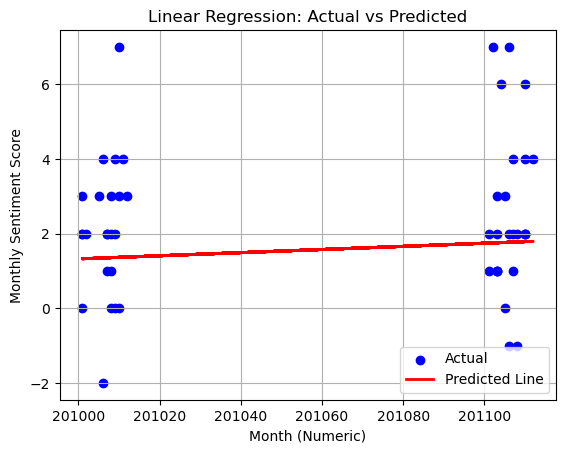

In [37]:
# ================ Actual vs Predicted Scatter Plot For LINEAR REGRESSION MODEL Before Feature Engineering==========================

plt.scatter(X_test, y_test, color='blue', label='Actual')     # Actual data points
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted Line')  # Regression line

plt.xlabel('Month (Numeric)')
plt.ylabel('Monthly Sentiment Score')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

## Enhanced Linear Regression Model with Additional Features

This section improves the predictive model by incorporating more relevant features:

- **Features added:**
  - `message_count`: Total messages sent by an employee in a month.
  - `positive_count`: Number of positive sentiment messages.
  - `negative_count`: Number of negative sentiment messages.
  - `neutral_count`: Number of neutral sentiment messages.
  - `month_int`: Numeric representation of the month (`YYYYMM`).

- The model is trained using these features to predict the **monthly sentiment score**.

- Data is split into training (70%) and testing (30%) sets to evaluate model performance.

- The linear regression model is fit on the training data, and predictions are made on the test set.

- Model evaluation metrics include Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²) score to assess accuracy and goodness of fit.

This approach aims to capture more nuanced patterns in employee sentiment trends, potentially improving prediction quality compared to the simpler model with only time as a feature.


In [38]:
# ======================= ADDING MORE FEATURES TO LINEAR REGRESSION MODEL (to improve it's performance) ===================

# Calculate monthly features per employee
monthly = df_bert.groupby(['from', 'month']).agg(
    monthly_score=('score', 'sum'),
    message_count=('sentiment_labels', 'count'),
    negative_count=('sentiment_labels', lambda x: (x == 'Negative').sum()),
    positive_count=('sentiment_labels', lambda x: (x == 'Positive').sum()),
    neutral_count=('sentiment_labels', lambda x: (x == 'Neutral').sum()),
).reset_index()

# Convert month to numeric for modeling
monthly['month_int'] = monthly['month'].astype(str).str.replace('-', '').astype(int)

# Prepare features and target
features = ['month_int', 'message_count', 'positive_count', 'negative_count', 'neutral_count']
X = monthly[features]
y = monthly['monthly_score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
# Tested with train_test_split with test_size = 0.2 and 0.3. Giving same results. No overfitting occurs.

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score            : {r2:.2f}")


Mean Squared Error : 0.00
Mean Absolute Error: 0.00
R² Score            : 1.00


"""
Metric	Value	Interpretation
MSE = 0.00	Your predictions exactly match the actual values (no squared error).	
MAE = 0.00	There is no average absolute error — the model is 100% accurate.	
R² = 1.00	The model explains 100% of the variance in the target variable.

"""

## Actual vs Predicted Sentiment Scores Scatter Plot (After Feature Engineering)

This scatter plot visualizes the relationship between the actual sentiment scores (`y_test`) and the predicted sentiment scores (`y_pred`) from the enhanced linear regression model.

- Each point represents one data instance from the test set.
- The red dashed line (`y = x`) represents the ideal scenario where predicted values perfectly match the actual values.
- Points close to this line indicate accurate predictions by the model.
- Deviations from the line indicate prediction errors.

This plot helps to visually assess the model’s prediction quality and how well it captures the sentiment trends after incorporating additional features.

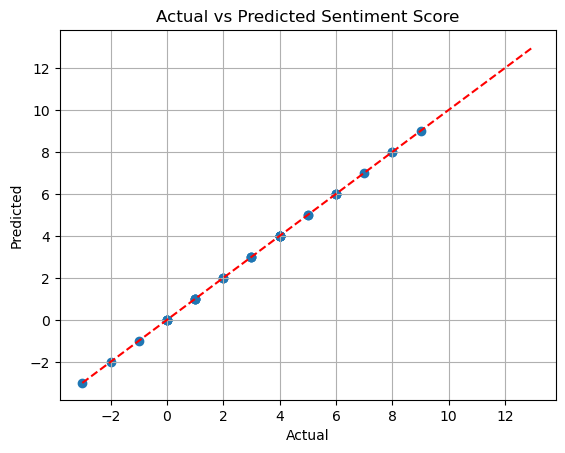

In [40]:
# ================ Actual vs Predicted Scatter Plot For LINEAR REGRESSION MODEL After Feature Engineering==========================

plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
#plt.plot(y_test, y_test, color='black', linestyle='--')  # perfect prediction line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Sentiment Score")
plt.grid(True)
plt.show()

In [ ]:
# ======================= CROSS VERIFYING RESULTS WITH RANDOM FOREST REGRESSOR =========================

## Data Preparation for Random Forest Regressor

Created a copy of the original dataframe `df_bert` named `df_RFR`.  
This preserves the original data while allowing experimentation and modeling with the Random Forest Regressor without affecting the original dataset.

In [41]:
df_RFR = df_bert.copy()  # creating a copy of database for Random forest Regressor (just a backup)


## Random Forest Regressor for Sentiment Score Prediction

- Aggregated monthly sentiment features per employee including total sentiment score, message count, and counts of positive, negative, and neutral messages.
- Converted month to a numeric format for modeling purposes.
- Selected relevant features and target variable for the regression task.
- Split the data into training (80%) and testing (20%) sets to evaluate model performance.
- Trained a Random Forest Regressor on the training data.
- Made predictions on the test set.
- Evaluated the model using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² score.
- Printed performance metrics to assess the model's predictive accuracy.

In [42]:
# ====================================== Random Forest Reggressor ======================

# Calculate monthly features per employee
monthly = df_RFR.groupby(['from', 'month']).agg(
    monthly_score=('score', 'sum'),
    message_count=('sentiment_labels', 'count'),
    negative_count=('sentiment_labels', lambda x: (x == 'Negative').sum()),
    positive_count=('sentiment_labels', lambda x: (x == 'Positive').sum()),
    neutral_count=('sentiment_labels', lambda x: (x == 'Neutral').sum()),
).reset_index()

# Convert month to numeric for modeling
monthly['month_int'] = monthly['month'].astype(str).str.replace('-', '').astype(int)

# Prepare features and target
features = ['month_int', 'message_count', 'positive_count', 'negative_count', 'neutral_count']
X = monthly[features]
y = monthly['monthly_score']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error : {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score            : {r2:.2f}")


Mean Squared Error : 0.78
Mean Absolute Error: 0.55
R² Score            : 0.91


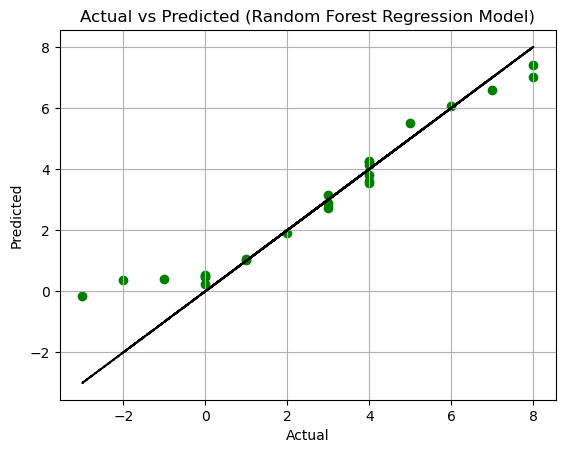

In [78]:
# ================ Actual vs Predicted Scatter Plot For RANDOM FOREST REGRESSION MODEL ==========================

plt.scatter(y_test, y_pred, color='green')
plt.plot(y_test, y_test, color='black', linestyle='--')  # perfect prediction line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Random Forest Regression Model)")
plt.grid(True)
plt.show()

## Feature Importance Visualization for Random Forest Regressor

- Extracted feature importance scores from the trained Random Forest model.
- Visualized the relative importance of each feature in predicting the monthly sentiment score using a horizontal bar chart.
- This helps to identify which features contribute most to the model's predictions.
- Features analyzed include month (numeric), message count, and counts of positive, negative, and neutral messages.

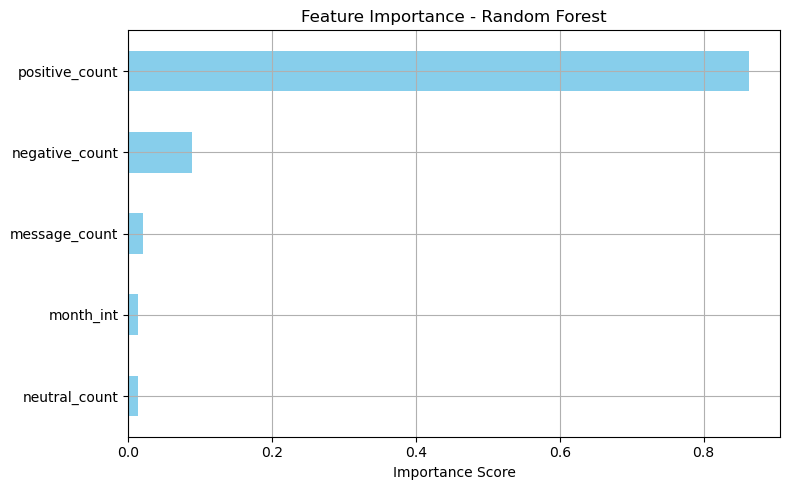

In [44]:
# ======== a Random Forest, visualize which features matter most =====================

# Assuming your features list
features = ['month_int', 'message_count', 'positive_count', 'negative_count', 'neutral_count']
importances = rf.feature_importances_

# Create a bar chart
plt.figure(figsize=(8, 5))
pd.Series(importances, index=features).sort_values().plot(kind='barh', color='skyblue')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()